In [1]:
#import modules
import loaddata
import pandas as pd
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import statsmodels.formula.api as smf
import patsy
from seaborn import plt
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV
from IPython.core.pylabtools import figsize

In [2]:
# load the data
movie_dicts = loaddata.load_mojo_data()
movie_df = pd.DataFrame(movie_dicts)

meta_dicts = loaddata.load_metacritic_data()
meta_df = pd.DataFrame(meta_dicts)

# merge the data 
movie_df['title_strip']=movie_df['title'].str.strip()
meta_df['title_strip']=meta_df['title'].str.strip()

movie_inner=movie_df.merge(meta_df,on='title_strip', how='inner')


Parsed 3728 movies from 3728 files
Parsed 4765 metacritic files from 4767 files


In [11]:
# create top directors indicators (by worldwide gross)
movie_inner['top_dir']=movie_inner['director_y'].apply(lambda x: 1 if x.find('Lee Unkrich')>=0 or x.find('James Cameron')>=0 
                                                       or x.find('Shane Black') or x.find('George Lucas') >= 0 else 0)


In [23]:
#big director
big_dirs=movie_inner.director_y.value_counts().index[:9]
movie_inner['big_dir']=movie_inner['director_x'].isin(big_dirs)
movie_inner['big_dir']=movie_inner['big_dir'].apply(lambda x: 1 if x==True else 0)

In [13]:
# create season column based on release date (summer, holiday, other)
movie_inner['mayjune']=movie_inner['release_date'].apply(lambda x: 1 if ('05' <= x[5:7] <= '06') 
                                                        else 0)

movie_inner['holiday']=movie_inner['release_date'].apply(lambda x: 1 if ('11' <= x[5:7] <= '12')
                                                        else 0)

In [14]:
# create genre columns
movie_inner['adventure']=movie_inner['genre'].apply(lambda x: 1 if x.find('Adventure')>=0 else 0)
movie_inner['action']=movie_inner['genre'].apply(lambda x: 1 if x.find('Action')>=0 else 0)
movie_inner['thriller']=movie_inner['genre'].apply(lambda x: 1 if x.find('Thriller')>=0 else 0)
movie_inner['fantasy']=movie_inner['genre'].apply(lambda x: 1 if x.find('Fantasy')>=0 else 0)
movie_inner['horror']=movie_inner['genre'].apply(lambda x: 1 if x.find('Horror')>=0 else 0)
movie_inner['scifi']=movie_inner['genre'].apply(lambda x: 1 if x.find('Sci-Fi')>=0 else 0)
movie_inner['romance']=movie_inner['genre'].apply(lambda x: 1 if x.find('Romance')>=0 else 0)
movie_inner['drama']=movie_inner['genre'].apply(lambda x: 1 if x.find('Drama')>=0 else 0)
movie_inner['comedy']=movie_inner['genre'].apply(lambda x: 1 if x.find('Comedy')>=0 else 0)
movie_inner['doc']=movie_inner['genre'].apply(lambda x: 1 if x.find('Documentary')>=0 else 0)
movie_inner['family']=movie_inner['genre'].apply(lambda x: 1 if x.find('Family')>=0 else 0)
movie_inner['bio']=movie_inner['genre'].apply(lambda x: 1 if x.find('Biography')>=0 else 0)
movie_inner['crime']=movie_inner['genre'].apply(lambda x: 1 if x.find('Crime')>=0 else 0)
movie_inner['war']=movie_inner['genre'].apply(lambda x: 1 if x.find('War')>=0 else 0)
movie_inner['animation']=movie_inner['genre'].apply(lambda x: 1 if x.find('Animation')>=0 else 0)
movie_inner['history']=movie_inner['genre'].apply(lambda x: 1 if x.find('History')>=0 else 0)
movie_inner['music']=movie_inner['genre'].apply(lambda x: 1 if x.find('Music')>=0 else 0)
movie_inner['western']=movie_inner['genre'].apply(lambda x: 1 if x.find('Western')>=0 else 0)

In [124]:
# create rating indicator col
movie_inner['g_pg_pg13']=movie_inner['rating'].apply(lambda x: 1 if (x=='PG-13' or x=='PG' or x=='G') else 0)
movie_inner['r']=movie_inner['rating'].apply(lambda x: 1 if (x.find('R')>=0) else 0)
movie_inner['g']=movie_inner['rating'].apply(lambda x: 1 if (x.find('G')==0) else 0)
movie_inner['notg_pg13']=movie_inner['g_pg_pg13'].apply(lambda x: 1 if x==0 else 0)

In [22]:
# big studios
big_studios=movie_inner.studio.value_counts().index[:9]
movie_inner['big_studio']=movie_inner['studio'].isin(big_studios)
movie_inner['big_studio']=movie_inner['big_studio'].apply(lambda x: 1 if x==True else 0)

In [64]:
# log domestic gross
movie_inner['ln_domestic_gross']=np.log(movie_inner['domestic_gross'])

In [65]:
# log production budget
movie_inner['ln_production_budget']=np.log(movie_inner['production_budget'])

In [126]:
# define features
features=['r','production_budget',
          'comedy','western','big_studio',
          'year_x']
related_columns = features + ['domestic_gross']

In [127]:
#clean the data
clean_movie = movie_inner[related_columns].dropna()
print '%i movies with all necessary info.' % len(clean_movie)

1449 movies with all necessary info.


In [128]:
# build a model
#import statsmodels.api as sma
Y = clean_movie['domestic_gross']
X = sma.add_constant(clean_movie[features])
dm_gross_model = sma.OLS(Y, X).fit()
dm_gross_model.summary()

#took out doc,music,romance,crime,pg13,action,bio,horror, scifi, family,war,adventure,thriller,holiday,drama,g,fantasy
#runtime,mayjune, animation, top_dir, fantasy

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         domestic_gross   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     110.8
Date:                Fri, 01 Jul 2016   Prob (F-statistic):          5.38e-115
Time:                        09:49:23   Log-Likelihood:                -27895.
No. Observations:                1449   AIC:                         5.580e+04
Df Residuals:                    1442   BIC:                         5.584e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const              3.314e+09   4.36e+08      7.601      0.000      2.46e+09  4.17e+09
r                 -1.238e+07   3.11e+06     -3.985      0.000     -1.85e+07 -6.28e+06
production_budget     0.8224      0.039     20.952      0.000         0.745     0.899
comedy             7.831e+06   3.06e+06      2.555      0.011      1.82e+06  1.38e+07
western           -2.301e+07   1.17e+07     -1.960      0.050      -4.6e+07  1.96e+04
big_studio         8.537e+06    3.1e+06      2.758      0.006      2.47e+06  1.46e+07
year_x            -1.641e+06   2.17e+05     -7.546      0.000     -2.07e+06 -1.21e+06
==============================================================================
Omnibus:                      746.168   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6715.122
Skew:                           2.224   Prob(JB):                         0.00
Kurtosis:                      12.562   Cond. No.                     1.82e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

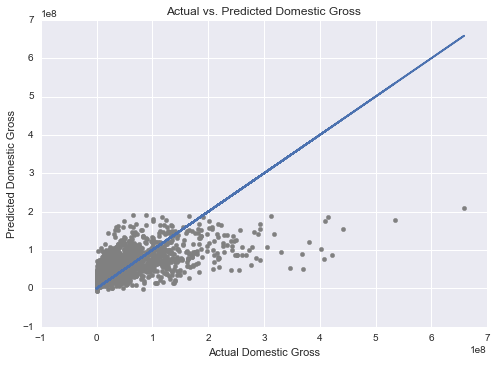

In [136]:
predicted_gross = dm_gross_model.predict(X)
plt.scatter(clean_movie.domestic_gross, predicted_gross, color='gray')
plt.plot(clean_movie.domestic_gross, clean_movie.domestic_gross)
plt.title("Actual vs. Predicted Domestic Gross")
plt.xlabel("Actual Domestic Gross")
plt.ylabel("Predicted Domestic Gross")

In [132]:
#really successful movies
blockbusters=movie_inner[movie_inner['domestic_gross']>=200000000]

In [156]:
blockbusters_genre['first_gen']=blockbusters_genre['genre_y'].apply(lambda x: x.split(',')[0])

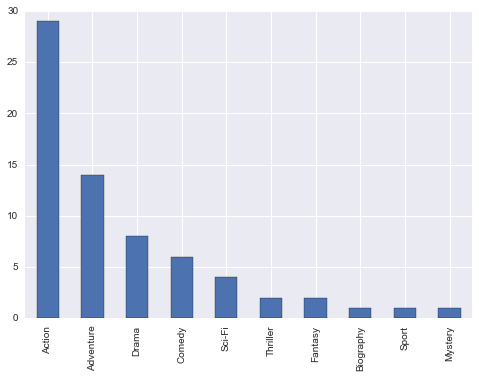

In [160]:
# first genre of 68 blockbusters
blockbusters_genre.first_gen.value_counts().plot(kind='bar')

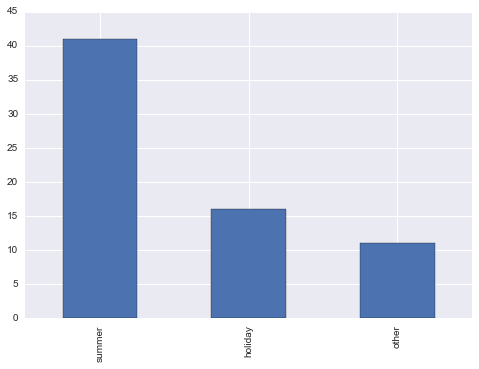

In [168]:
# create season column based on release date (summer, holiday, other)
blockbusters_genre['season']=blockbusters_genre['release_date'].apply(lambda x: 'summer' if ('05' <= x[5:7] <= '07')
                                                                        else 'holiday' if ('11' <= x[5:7] <= '12')
                                                        else 'other')
blockbusters_genre.season.value_counts().plot(kind='bar')

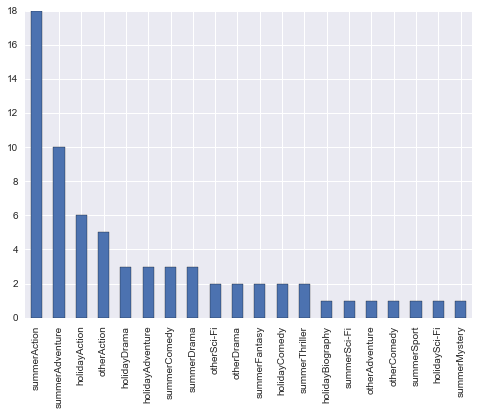

In [175]:
# interaction blockbusters seasonxfirst_gen
blockbusters_genre['season_genre']=blockbusters_genre['season']+blockbusters_genre['first_gen']
blockbusters_genre.season_genre.value_counts().plot(kind='bar')

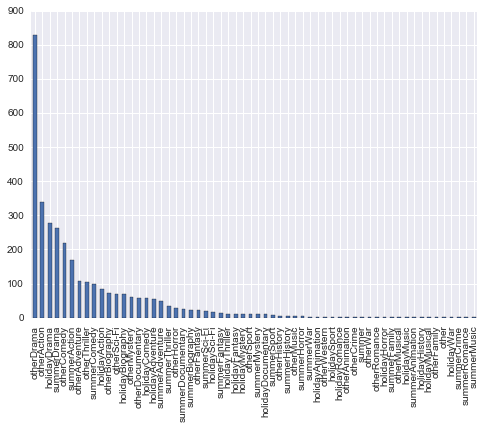

In [177]:
# interaction overall seasonxfirst_gen
movie_inner['season']=movie_inner['release_date'].apply(lambda x: 'summer' if ('05' <= x[5:7] <= '07')
                                                                        else 'holiday' if ('11' <= x[5:7] <= '12')
                                                        else 'other')
movie_inner['first_gen']=movie_inner['genre'].apply(lambda x: x.split(',')[0])
movie_inner['season_genre']=movie_inner['season']+movie_inner['first_gen']
movie_inner.season_genre.value_counts().plot(kind='bar')

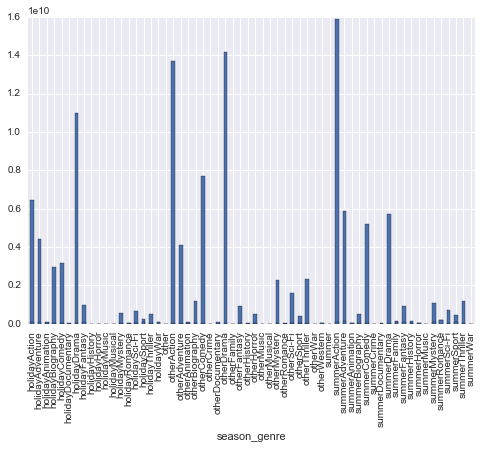

In [181]:
#overall season_genre average domestic (summer action makes most $$)
movie_inner['domestic_gross'].groupby(movie_inner['season_genre']).sum().plot(kind='bar')

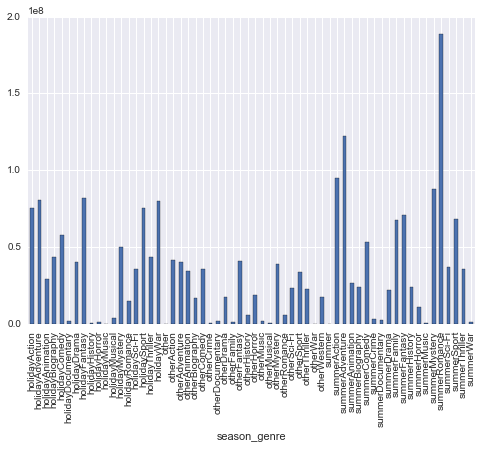

In [182]:
# average overall dom gross by season genre (summer romance hedge your bets)
movie_inner['domestic_gross'].groupby(movie_inner['season_genre']).mean().plot(kind='bar')

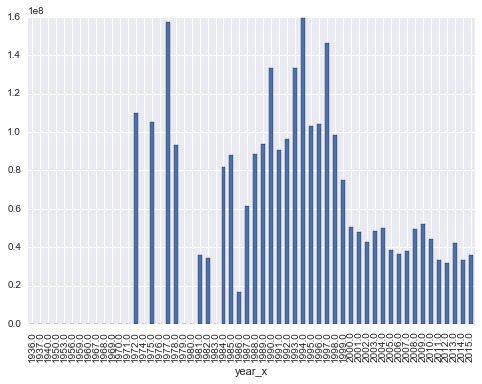

In [171]:
# overall sample year by worldwide-domestic
movie_inner['foreign']=movie_inner['worldwide_gross']-movie_inner['domestic_gross']
movie_inner['foreign'].groupby(movie_inner['year_x']).mean().plot(kind='bar')